# SVC w/ Hiperparameter tunning (Grid Search, Random Search, Bayesian Opt, Bayes search, Optuna) & lifecycle management w/ MLFLOW

In [1]:
# Importa librerias
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import cross_val_score, train_test_split

from scipy.stats import uniform

from sklearn.metrics import classification_report, roc_curve, auc

## Data loading & preprocessing

In [2]:
# Lee dataset
cols = ["fLength", "fWidth", "fSize", "fConc", "fConc1", "fAsym", "fM3Long", "fM3Trans", "fAlpha", "fDist", "class"]
df = pd.read_csv("../../data/raw/magic04.data", names=cols)
df.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [3]:
# Valores de la variable objetivo
df['class'].unique()

array(['g', 'h'], dtype=object)

In [4]:
# Reclasifica variable objetivo - Class as int (g=1, h=0)

df['class'] = (df['class'] == "g").astype(int)

### General parameters

In [5]:
# Todos
cv=3                 # cross validation
random_state=22      # random seed
n_jobs=-1            # paralelized jobs 

# Trials
n_iter=10            # BayesSearchCV, BayesianOptimization, RandomizedSearchCV
n_trials=15           # Optuna trials 
init_points=2        # BayesianOptimization

# SVC range params
c_min=1e-3
c_max=1e+3
gamma_min=1e-4
gamma_max=1e+1

# Other
import datetime
mlf_key = datetime.datetime.now().strftime("%y%m%d%H%M")

### Split dataset

In [6]:
# Shuffle with a fixed random state for reproducibility
data_shuffled = df.sample(frac=1, random_state=random_state)  

# Split data into training and temporary sets (80% training, 20% temp)
df_train, df_temp = train_test_split(data_shuffled, test_size=0.4, random_state=random_state)

# Split the temporary set into testing and validation sets (50% test, 50% validation)
df_test, df_valid = train_test_split(df_temp, test_size=0.5, random_state=random_state)

# Reset the indices of the resulting DataFrames
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_valid.reset_index(drop=True, inplace=True)

### Function for scaling and oversampling the dataset

In [7]:
def scale_dataset(df_param, random_state=None, oversample = False):
  X = df_param[df_param.columns[:-1]].values
  y = df_param[df_param.columns[-1]].values

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

  if oversample:
    ros = RandomOverSampler(random_state=random_state)
    X, y = ros.fit_resample(X, y)

  data = np.hstack((X, np.reshape(y, (-1, 1))))

  return data, X, y

### Scale & oversample

In [8]:
train, X_train, y_train = scale_dataset(df_train, random_state, oversample = True)
valid, X_valid, y_valid = scale_dataset(df_valid, random_state, oversample = False)
test, X_test, y_test = scale_dataset(df_test, random_state, oversample = False)

###

In [9]:
import os
# Save to CSV for logging
X_train_path = os.path.abspath("../../data/processed/X_train.csv")
y_train_path = os.path.abspath("../../data/processed/y_train.csv")
X_test_path = os.path.abspath("../../data/processed/X_test.csv")
y_test_path = os.path.abspath("../../data/processed/y_test.csv")
X_valid_path = os.path.abspath("../../data/processed/X_valid.csv")
y_valid_path = os.path.abspath("../../data/processed/y_valid.csv")

pd.DataFrame(X_train).to_csv(X_train_path, index=False)
pd.DataFrame(y_train).to_csv(y_train_path, index=False)
pd.DataFrame(X_test).to_csv(X_test_path, index=False)
pd.DataFrame(y_test).to_csv(y_test_path, index=False)
pd.DataFrame(X_valid).to_csv(X_valid_path, index=False)
pd.DataFrame(y_valid).to_csv(y_valid_path, index=False)

## MLFLow

### Initialize MLFlow experiment

In [10]:
import mlflow

# Code for init MLFLOW server: mlflow server --host 127.0.0.1 --port 5000
mlf_tracking_server_uri = "http://localhost:5000"
mlflow.set_tracking_uri(mlf_tracking_server_uri)

mlf_experiment_name = 'Magic'
mlf_experiment_description = "This is a(n) " + mlf_experiment_name + " experiment initiated on " + mlf_key
mlf_experiment_tags = {
    "project_name": "Magic Project",
    "team": "Local Py",
    "mlflow.note.content": mlf_experiment_description,
}

try:
    mlf_exp_id = mlflow.create_experiment(name=mlf_experiment_name, tags=mlf_experiment_tags)
except Exception as e:
    mlf_exp_id = mlflow.get_experiment_by_name(mlf_experiment_name).experiment_id

mlflow.sklearn.autolog(disable=True)    
#print("Experiment ID:", mlf_exp_id)

### MLFlow procedures

In [11]:
def mlf_log_tags_params (model_name, model_desc, C, gamma, kernel, X_train_path, y_train_path, X_test_path, y_test_path):
    mlflow.set_tag("model_name", model_name)          
    mlflow.set_tag("model_description", model_desc)
    mlflow.set_tag('X_Train', X_train_path) 
    mlflow.set_tag('y_train', y_train_path) 
    mlflow.set_tag('X_test', X_test_path) 
    mlflow.set_tag('y_test', y_test_path) 
    mlflow.log_param('C', C)    
    mlflow.log_param('gamma', gamma)    
    mlflow.log_param('kernel', kernel)  

def mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max):    
    mlflow.set_tag("cv", cv)  
    mlflow.set_tag("random_state", random_state) 
    mlflow.set_tag("n_jobs", n_jobs) 
    mlflow.set_tag("n_iter", n_iter) 
    mlflow.set_tag("n_trials", n_trials) 
    mlflow.set_tag("init_points", init_points) 
    mlflow.set_tag("c_min", c_min) 
    mlflow.set_tag("c_max", c_max) 
    mlflow.set_tag("gamma_min", gamma_min) 
    mlflow.set_tag("gamma_max", gamma_max) 


def mlf_log_metrics_models(class_report, model, tag, auc):
    #class_report = classification_report(y_test, y_pred, output_dict=True)

    # mlflow.log_metric("test_accuracy", test_accuracy)  
    mlflow.log_metric("accuracy", class_report["accuracy"])
    mlflow.log_metric("AUC", auc)
    
    for class_name, metrics in class_report.items():
        if class_name not in ["macro avg", "weighted avg"]:
            if isinstance(metrics, dict):  # Check if metrics is a dictionary
                for metric, value in metrics.items():
                    if metric in ["precision", "recall", "f1-score", "support"]:
                        mlflow.log_metric(f"{metric}_{class_name}", value)    
    mlflow.sklearn.log_model(model, tag) 
    #mlflow.log_figure(fig8, "qq_plot.png")

def log_metrics_auc_intervals(svc_fpr, svc_tpr):
    # Define the intervals (e.g., 10%, 20%, ..., 90%)
    intervals = range(10, 91, 10)  # 10, 20, ..., 90
    
    # Initialize a dictionary to store the AUC for each interval
    auc_intervals = {}
    
    # Compute the total number of data points
    total_points = len(svc_fpr)
    
    # Loop through each interval
    for interval in intervals:
        # Calculate the index up to which the current interval falls
        index = int((interval / 100) * total_points)
        
        # Extract the FPR and TPR values up to the current index
        fpr_interval = svc_fpr[:index + 1]
        tpr_interval = svc_tpr[:index + 1]
        
        # Compute the AUC for the current interval
        auc_interval = auc(fpr_interval, tpr_interval)
        
        # Store the AUC for the current interval
        auc_intervals[interval] = auc_interval
    
    for interval, auc_interval in auc_intervals.items():
        #print(f"AUC for {interval}%: {auc_interval}")  
        mlflow.log_metric(f"AUC for {interval} perc", auc_interval)
    

## Model

### SVC base

In [12]:
%%time

from sklearn.svm import SVC

with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_Baseline'):  
    #mlflow.sklearn.autolog()
    
    svc_model = SVC(random_state=random_state)
    svc_model.fit(X_train, y_train)
    y_pred = svc_model.predict(X_test)
    y_pred_base = svc_model.decision_function(X_test)
    
    # Get the hyperparameters of the trained model
    best_params = svc_model.get_params()

    # mlflow.set_tag("model_name", "SVC_Baseline" )          
    # mlflow.set_tag("model_description", "Baseline Support Vector Classifier")
    # mlflow.log_param('C', best_params['C'])    
    # mlflow.log_param('gamma', best_params['gamma'])    
    # mlflow.log_param('kernel', best_params['kernel'])  
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_Baseline", "Baseline SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    #mlflow.log_params(model_hyperparameters)    
    
    # Print the hyperparameters
    # print("Hyperparameters of the trained SVC model:")
    # for param, value in model_hyperparameters.items():
    #     print(f"{param}: {value}")
    
    # test_accuracy = svc_model.score(X_test, y_test)
    # print("Test Accuracy of Best Model:", test_accuracy)

    # print(classification_report(y_test, y_pred))
    
    # class_report = classification_report(y_test, y_pred, output_dict=True)

    # # mlflow.log_metric("test_accuracy", test_accuracy)  
    # mlflow.log_metric("accuracy", class_report["accuracy"])
    
    # for class_name, metrics in class_report.items():
    #     if class_name not in ["macro avg", "weighted avg"]:
    #         if isinstance(metrics, dict):  # Check if metrics is a dictionary
    #             for metric, value in metrics.items():
    #                 if metric in ["precision", "recall", "f1-score", "support"]:
    #                     mlflow.log_metric(f"{metric}_{class_name}", value)
    
    # mlflow.sklearn.log_model(svc_model, "SVC_Baseline")  
    base_fpr, base_tpr, threshold = roc_curve(y_test, y_pred_base)
    auc_base = auc(base_fpr, base_tpr)
    
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), svc_model, "SVC_Baseline", auc_base)
    log_metrics_auc_intervals(base_fpr, base_tpr)
    
    mlflow.end_run()

2024/03/05 18:24:57 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



CPU times: total: 15.7 s
Wall time: 21.5 s


### SVC Grid search

In [13]:
%%time

# SVM Grid search
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the grid search
param_grid = {
    # 'kernel': ['linear', 'rbf', 'poly'],    # Types of kernel functions
    # 'C': [0.001, 1, 50, 100, 1000],                 # Values of the regularization parameter
    # 'gamma': ['scale', 'auto']              # Kernel coefficient for 'rbf' kernel

    'kernel': ['linear'],    
    'C': [0.001, 1],                 
    'gamma': ['scale', 'auto']              
    }

# Create the GridSearchCV object
grid_search_svc = GridSearchCV(svc_model, param_grid, cv=cv, scoring='accuracy', verbose=2)

# Perform the grid search on the training data
grid_search_svc.fit(X_train, y_train)

with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_GridSearch'):  
    #mlflow.sklearn.autolog()
    
    # Print the best parameters and the corresponding accuracy
    best_params = grid_search_svc.best_params_
    ##print("Best Parameters:", grid_search_svm.best_params_)
    ##print("Best Accuracy:", grid_search_svm.best_score_)
    
    # Evaluate the best model on the test data
    best_svc = grid_search_svc.best_estimator_
    ##test_accuracy = best_svc.score(X_test, y_test)
    ##print("Test Accuracy of Best Model:", test_accuracy)
    
    y_pred = best_svc.predict(X_test)
    y_pred_gridsearch = best_svc.decision_function(X_test)
    ##print(classification_report(y_test, y_pred))

    # mlflow.set_tag("model_name", "SVC_best_gridsearch")                  
    # mlflow.set_tag("model_description", "Best Grid Search Support Vector Classifier")
    # mlflow.log_param('C', best_params['C'])    
    # mlflow.log_param('gamma', best_params['gamma'])    
    # mlflow.log_param('kernel', best_params['kernel'])    
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_gridsearch", "Best Grid Search SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # mlflow.log_metric("accuracy", class_report["accuracy"])
    
    # for class_name, metrics in class_report.items():
    #     if class_name not in ["macro avg", "weighted avg"]:
    #         if isinstance(metrics, dict):  # Check if metrics is a dictionary
    #             for metric, value in metrics.items():
    #                 if metric in ["precision", "recall", "f1-score", "support"]:
    #                     mlflow.log_metric(f"{metric}_{class_name}", value)
    

    # mlflow.sklearn.log_model(best_svc, "SVC_best_GridSearch")  

    gridsearch_svc_fpr, gridsearch_svc_tpr, threshold = roc_curve(y_test, y_pred_gridsearch)
    auc_gridsearch_svc = auc(gridsearch_svc_fpr, gridsearch_svc_tpr)
    
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_GridSearch", auc_gridsearch_svc)
    log_metrics_auc_intervals(gridsearch_svc_fpr, gridsearch_svc_tpr)

    mlflow.end_run()


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   4.6s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   3.7s
[CV] END ................C=0.001, gamma=scale, kernel=linear; total time=   3.6s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   3.8s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   4.3s
[CV] END .................C=0.001, gamma=auto, kernel=linear; total time=   3.6s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.2s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   5.9s
[CV] END ....................C=1, gamma=scale, kernel=linear; total time=   4.7s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   5.6s
[CV] END .....................C=1, gamma=auto, kernel=linear; total time=   5.7s
[CV] END .....................C=1, gamma=auto, ke

C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 1min 8s
Wall time: 1min 12s


### SVC Random search

In [14]:
%%time

# SVM Random search
from sklearn.model_selection import RandomizedSearchCV

## Define parameter distributions
param_dist = {'C': uniform(c_min, c_max),
              'gamma': ['scale', 'auto'],
 #'gamma': uniform(0.01, 10),
              'kernel': ['rbf', 'linear', 'poly']}
# Create the RandomizedSearchCV object
random_search_svm = RandomizedSearchCV(svc_model, param_distributions=param_dist, cv=cv, n_iter=n_iter, random_state=random_state, verbose=2)

# Perform the random search on the training data
random_search_svm.fit(X_train, y_train)


with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_RandomSearch'):  
    #mlflow.sklearn.autolog()
    
    best_params = random_search_svm.best_params_
    # Print best parameters and accuracy
    ## print('Best parameters:', random_search_svm.best_params_)
    ## print('Best accuracy:', random_search_svm.best_score_)
    
    # Evaluate the best model on the test data
    best_svc = random_search_svm.best_estimator_
    ##test_accuracy = best_model.score(X_test, y_test)
    ##print("Test Accuracy of Best Model:", test_accuracy)
    
    y_pred = best_svc.predict(X_test)
    y_pred_randomsearch = best_svc.decision_function(X_test)
    ##print(classification_report(y_test, y_pred))

    # mlflow.set_tag("model_name", "SVC_best_randomsearch")                  
    # mlflow.set_tag("model_description", "Best Random Search Support Vector Classifier")
    # mlflow.log_param('C', best_params['C'])    
    # mlflow.log_param('gamma', best_params['gamma'])    
    # mlflow.log_param('kernel', best_params['kernel'])    
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_randomsearch", "Best Random Search SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # mlflow.log_metric("accuracy", class_report["accuracy"])
    
    # for class_name, metrics in class_report.items():
    #     if class_name not in ["macro avg", "weighted avg"]:
    #         if isinstance(metrics, dict):  # Check if metrics is a dictionary
    #             for metric, value in metrics.items():
    #                 if metric in ["precision", "recall", "f1-score", "support"]:
    #                     mlflow.log_metric(f"{metric}_{class_name}", value)
    

    # mlflow.sklearn.log_model(best_svc, "SVC_best_RandomSearch")  

    randomsearch_svc_fpr, randomsearch_svc_tpr, threshold = roc_curve(y_test, y_pred_randomsearch)
    auc_randomsearch_svc = auc(randomsearch_svc_fpr, randomsearch_svc_tpr)

    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_RandomSearch", auc_randomsearch_svc)
    log_metrics_auc_intervals(randomsearch_svc_fpr, randomsearch_svc_tpr)
    
    mlflow.end_run()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ......C=208.46153735884263, gamma=scale, kernel=rbf; total time=  11.4s
[CV] END ......C=208.46153735884263, gamma=scale, kernel=rbf; total time=  10.3s
[CV] END ......C=208.46153735884263, gamma=scale, kernel=rbf; total time=  12.4s
[CV] END .......C=420.5390353143747, gamma=scale, kernel=rbf; total time=  16.6s
[CV] END .......C=420.5390353143747, gamma=scale, kernel=rbf; total time=  16.2s
[CV] END .......C=420.5390353143747, gamma=scale, kernel=rbf; total time=  16.7s
[CV] END ....C=846.7099857076403, gamma=scale, kernel=linear; total time= 7.6min
[CV] END ....C=846.7099857076403, gamma=scale, kernel=linear; total time= 7.1min
[CV] END ....C=846.7099857076403, gamma=scale, kernel=linear; total time= 7.4min
[CV] END ...C=234.63865301586205, gamma=scale, kernel=linear; total time= 2.4min
[CV] END ...C=234.63865301586205, gamma=scale, kernel=linear; total time= 2.3min
[CV] END ...C=234.63865301586205, gamma=scale, k

C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 50min 45s
Wall time: 51min 14s


### SVC Bayesian optimization

In [15]:
%%time

# SVM Bayesian optimization - BayesianOptimization

from bayes_opt import BayesianOptimization

kernel='rbf' ########

def svm_cv(C, gamma):
    """SVM objective function with cross-validation."""
    svm = SVC(C=C, gamma=gamma, kernel=kernel, random_state=random_state) ### en vez de usar svm se puede pasar el svc_model / capaz cambiar el nombre de la funcion
    scores = cross_val_score(svm, X_train, y_train, cv=cv, scoring='accuracy')
    return np.mean(scores)

# Define the search space
pbounds = {'C': (c_min, c_max), 
           'gamma': (gamma_min, gamma_max)
          }

# Create the Bayesian optimizer
bayes_optimizer_svm = BayesianOptimization(
    f=svm_cv,
    pbounds=pbounds,
    random_state=random_state  # For reproducibility
)

# Optimize over n_iter iterations
bayes_optimizer_svm.maximize(init_points=init_points, n_iter=n_iter)

with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_BayesianOptimization'):  
    #mlflow.sklearn.autolog()
    
    # Get the best parameters
    best_params = bayes_optimizer_svm.max['params']
    
    # Print best parameters and accuracy
    ##print("Best parameters:", bayes_optimizer_svm.max['params'])      
    ##print("Best target:", bayes_optimizer_svm.max['target'])  
    
    # Train the SVM with the best parameters
    best_svc = SVC(**best_params)
    best_svc.fit(X_train, y_train)

    # best_params2 = best_svc.get_params()
    # print(best_params2['C'])
    # print(best_params2['gamma'])
    # print(best_params2['kernel'])
    ##test_accuracy = best_model.score(X_test, y_test)
    ##print("Test Accuracy of Best Model:", test_accuracy)
    
    # Use the trained SVM for prediction
    y_pred = best_svc.predict(X_test)
    y_pred_bayesianoptimization = best_svc.decision_function(X_test)
    ##print(classification_report(y_test, y_pred))

    # mlflow.set_tag("model_name", "SVC_best_BayesianOptimization")                  
    # mlflow.set_tag("model_description", "Best Bayesian Optimization Support Vector Classifier")
    # mlflow.log_param('C', best_params['C'])    
    # mlflow.log_param('gamma', best_params['gamma'])    
    # mlflow.log_param('kernel', kernel)    
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_BayesianOptimization", "Best Bayesian Optimization SVC", best_params['C'], best_params['gamma'], best_svc.get_params()['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # mlflow.log_metric("accuracy", class_report["accuracy"])
    
    # for class_name, metrics in class_report.items():
    #     if class_name not in ["macro avg", "weighted avg"]:
    #         if isinstance(metrics, dict):  # Check if metrics is a dictionary
    #             for metric, value in metrics.items():
    #                 if metric in ["precision", "recall", "f1-score", "support"]:
    #                     mlflow.log_metric(f"{metric}_{class_name}", value)
    

    # mlflow.sklearn.log_model(best_svc, "SVC_best_BayesianOptimization")  
    bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr, threshold = roc_curve(y_test, y_pred_bayesianoptimization)
    auc_bayesianoptimization_svc = auc(bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr)
    
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_BayesianOptimization", auc_bayesianoptimization_svc)
    log_metrics_auc_intervals(bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr)
    
    mlflow.end_run()

|   iter    |  target   |     C     |   gamma   |
-------------------------------------------------
| 1         | 0.8776    | 208.5     | 4.817     |
| 2         | 0.8356    | 420.5     | 8.592     |
| 3         | 0.8786    | 207.6     | 4.111     |
| 4         | 0.8655    | 168.9     | 0.07997   |
| 5         | 0.8552    | 959.5     | 9.877     |
| 6         | 0.8423    | 697.0     | 0.007256  |
| 7         | 0.7756    | 266.7     | 0.0001    |
| 8         | 0.8342    | 885.8     | 8.083     |
| 9         | 0.8538    | 97.72     | 9.538     |
| 10        | 0.8732    | 29.3      | 0.2464    |
| 11        | 0.6598    | 0.04192   | 9.374     |
| 12        | 0.7703    | 49.9      | 0.0001    |


C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 8min 37s
Wall time: 8min 46s


### SVC Bayes search

In [16]:
%%time
# SVM Bayesian optimization - BayesSearchCV

from skopt import BayesSearchCV

# Define the search space
param_space = {
    'C': (c_min, c_max, 'log-uniform'),  # C: Regularization parameter
    'gamma': (gamma_min, gamma_max, 'log-uniform')  # gamma: Kernel coefficient
}

# Initialize BayesSearchCV object
bayes_search_svm = BayesSearchCV(
    SVC(random_state=random_state), # pasar svc_model
    param_space,
    n_iter=n_iter,
    n_jobs=n_jobs,
    cv=cv
)

with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_BayesSearch'): 
    #mlflow.sklearn.autolog()
    
    # Perform optimization
    bayes_search_svm.fit(X_train, y_train)

    best_params = bayes_search_svm.best_params_
    # Print best parameters and accuracy
    ##print('Best parameters:', bayes_search_svm.best_params_)
    ##print('Best accuracy:', bayes_search_svm.best_score_)

    best_params = bayes_search_svm.best_params_

    
    # Evaluate the best model on the test data
    best_svc = bayes_search_svm.best_estimator_
    ##test_accuracy = best_model.score(X_test, y_test)
    ##print("Test Accuracy of Best Model:", test_accuracy)

    # best_params2 = best_svc.get_params()
    # print(best_params2['C'])
    # print(best_params2['gamma'])
    # print(best_params2['kernel'])
    
    y_pred = best_svc.predict(X_test)
    y_pred_bayessearch = best_svc.decision_function(X_test)
    ##print(classification_report(y_test, y_pred))

    # mlflow.set_tag("model_name", "SVC_best_BayesSearch")                  
    # mlflow.set_tag("model_description", "Best Bayes Search Support Vector Classifier")
    # mlflow.log_param('C', best_params['C'])    
    # mlflow.log_param('gamma', best_params['gamma'])    
    # mlflow.log_param('kernel', kernel)    
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_BayesSearch", "Best Bayes Search SVC", best_params['C'], best_params['gamma'], best_svc.get_params()['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    
    # class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # mlflow.log_metric("accuracy", class_report["accuracy"])
    
    # for class_name, metrics in class_report.items():
    #     if class_name not in ["macro avg", "weighted avg"]:
    #         if isinstance(metrics, dict):  # Check if metrics is a dictionary
    #             for metric, value in metrics.items():
    #                 if metric in ["precision", "recall", "f1-score", "support"]:
    #                     mlflow.log_metric(f"{metric}_{class_name}", value)
    

    # mlflow.sklearn.log_model(best_svc, "SVC_best_BayesSearch")  
    bayessearch_svc_fpr, bayessearch_svc_tpr, threshold = roc_curve(y_test, y_pred_bayessearch)
    auc_bayessearch_svc = auc(bayessearch_svc_fpr, bayessearch_svc_tpr)
    
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_BayesSearch", auc_bayessearch_svc)
    log_metrics_auc_intervals(bayessearch_svc_fpr, bayessearch_svc_tpr)
    
    mlflow.end_run()

C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\Ale\anaconda3\envs\ML101\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


CPU times: total: 40.6 s
Wall time: 4min 59s


### SVC Optuna

In [17]:
%%time

import optuna
from optuna.samplers import TPESampler
#import optuna.visualization as vis

def objective(trial):
    C = trial.suggest_float('C', c_min, c_max, log=True)
    gamma = trial.suggest_float('gamma', gamma_min, gamma_max, log=True)    
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf'])

    svc = SVC(C=C, gamma=gamma, kernel=kernel)
    
    # Supongamos que X_train, y_train están definidos
    score = cross_val_score(svc, X_train, y_train, n_jobs=n_jobs, cv=cv).mean()

    # with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_trial_Optuna_' + str(trial.number)):  
    #     mlflow.log_params(trial.params)
    #     mlflow.log_metric('score', score)
    #     # Set Optuna's trial id as the parent run ID for tracking
    #     mlflow.set_tag("parent_id", str(trial.number))
    #     mlflow.end_run()
    return score

pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(sampler=TPESampler(), direction='maximize', pruner=pruner)
study.optimize(objective, n_trials=n_trials)

with mlflow.start_run(experiment_id=mlf_exp_id, run_name= mlf_key + '_SVC_best_Optuna'):  
    #mlflow.sklearn.autolog()
    
    # Obtener los mejores hiperparámetros
    best_params = study.best_params
    
    # Crear el modelo con los mejores hiperparámetros
    best_svc = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'])
    best_svc.fit(X_train, y_train)
    
    # Hacer predicciones en el conjunto de prueba
    y_pred = best_svc.predict(X_test)
    y_pred_optuna = best_svc.decision_function(X_test)
    ##print(classification_report(y_test, y_pred))
    ##test_accuracy = best_svc.score(X_test, y_test)

    # mlflow.set_tag("model_name", "SVC_best_Optuna")                  
    # mlflow.set_tag("model_description", "Best Optuna Support Vector Classifier")
    # mlflow.log_param('C', best_params['C'])    
    # mlflow.log_param('gamma', best_params['gamma'])    
    # mlflow.log_param('kernel', best_params['kernel'])    
    mlf_log_tags_gen (cv, random_state, n_jobs, n_iter, n_trials, init_points, c_min, c_max, gamma_min, gamma_max)
    mlf_log_tags_params("SVC_best_Optuna", "Best Optuna SVC", best_params['C'], best_params['gamma'], best_params['kernel'], X_train_path, y_train_path, X_test_path, y_test_path)
    # Imprimir los resultados
    ##print("Best Hyperparameters:", best_params)
    ##print("Test Accuracy of Best Model:", test_accuracy)
    
    # class_report = classification_report(y_test, y_pred, output_dict=True)
    
    # ##mlflow.log_metric("test_accuracy", test_accuracy)  

    # mlflow.log_metric("accuracy", class_report["accuracy"])
    
    # for class_name, metrics in class_report.items():
    #     if class_name not in ["macro avg", "weighted avg"]:
    #         if isinstance(metrics, dict):  # Check if metrics is a dictionary
    #             for metric, value in metrics.items():
    #                 if metric in ["precision", "recall", "f1-score", "support"]:
    #                     mlflow.log_metric(f"{metric}_{class_name}", value)
    
    # mlflow.sklearn.log_model(best_svc, "SVC_best_Optuna")  
    optuna_svc_fpr, optuna_svc_tpr, threshold = roc_curve(y_test, y_pred_optuna)
    auc_optuna_svc = auc(optuna_svc_fpr, optuna_svc_tpr)
    
    mlf_log_metrics_models(classification_report(y_test, y_pred, output_dict=True), best_svc, "SVC_best_Optuna", auc_optuna_svc)
    log_metrics_auc_intervals(optuna_svc_fpr, optuna_svc_tpr)
    
    mlflow.end_run()

[I 2024-03-05 19:31:32,272] A new study created in memory with name: no-name-bd464469-1d33-4314-8cff-cef0fa291060
[I 2024-03-05 19:31:44,029] Trial 0 finished with value: 0.7875203295676413 and parameters: {'C': 85.49395572895142, 'gamma': 0.00041976852283743366, 'kernel': 'rbf'}. Best is trial 0 with value: 0.7875203295676413.
[I 2024-03-05 19:32:12,685] Trial 1 finished with value: 0.8364688824781306 and parameters: {'C': 4.051293030826236, 'gamma': 6.914507360214266, 'kernel': 'rbf'}. Best is trial 1 with value: 0.8364688824781306.
[I 2024-03-05 19:32:29,750] Trial 2 finished with value: 0.8856834731738834 and parameters: {'C': 91.98544497363228, 'gamma': 1.1691455693091473, 'kernel': 'rbf'}. Best is trial 2 with value: 0.8856834731738834.
[I 2024-03-05 19:32:43,097] Trial 3 finished with value: 0.7750810131813619 and parameters: {'C': 0.18992316949510005, 'gamma': 0.00614418365848995, 'kernel': 'rbf'}. Best is trial 2 with value: 0.8856834731738834.
[I 2024-03-05 19:32:51,447] Tria

CPU times: total: 58.3 s
Wall time: 1h 11min 44s


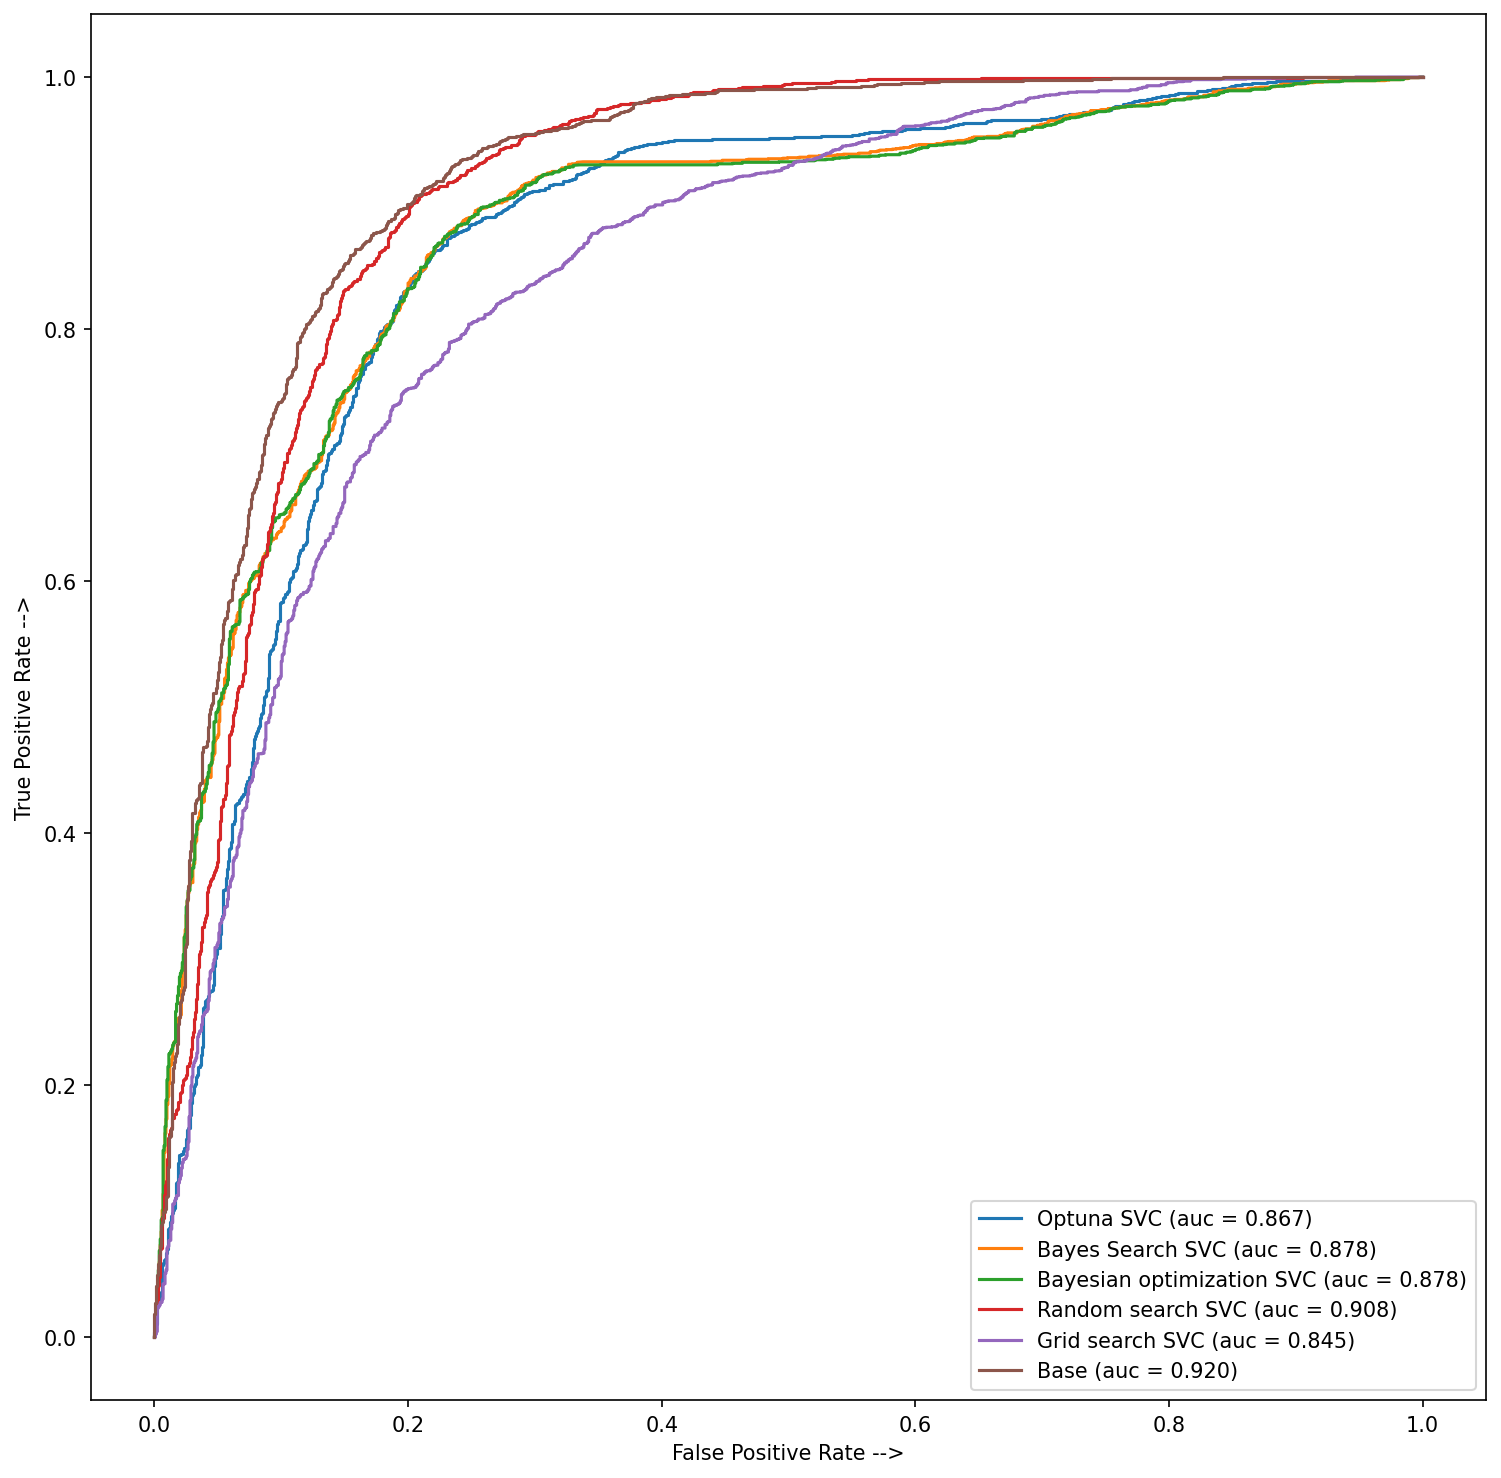

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12), dpi=150)
plt.plot(optuna_svc_fpr, optuna_svc_tpr, label='Optuna SVC (auc = %0.3f)' % auc_optuna_svc)
plt.plot(bayessearch_svc_fpr, bayessearch_svc_tpr, label='Bayes Search SVC (auc = %0.3f)' % auc_bayessearch_svc)
plt.plot(bayesianoptimization_svc_fpr, bayesianoptimization_svc_tpr, label='Bayesian optimization SVC (auc = %0.3f)' % auc_bayesianoptimization_svc)
plt.plot(randomsearch_svc_fpr, randomsearch_svc_tpr, label='Random search SVC (auc = %0.3f)' % auc_randomsearch_svc)
plt.plot(gridsearch_svc_fpr, gridsearch_svc_tpr, label='Grid search SVC (auc = %0.3f)' % auc_gridsearch_svc)
plt.plot(base_fpr, base_tpr, label='Base (auc = %0.3f)' % auc_base)

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [19]:
# MLflow guarda los resultados sin especificar bd? - si
# agregar como metrica resultados del classification report - si
# agregar descripcion - si
# hacer que cargue todas las corridas de optuna? - si
# hacer que la aleatoriedad al hacer validation y test sean fijas - si
# meter los demas algoritmos - base - optuna - gridsearch - random search - bayesian optimization - bayes search - si
# poner en funciones lo de MLFlow, optuna quizas - si
# guardar dataset (train/test/val) en mlflow - si
# guardar criterios de split dataset (train/test/val) en mlflow - si
# guardar ini/fin de algoritmos - si
# guardar parametros generales - si
# que pasa al correr varias veces esto con el experimento - si
#    hacer que cargue diferentes valores? - si
# validar si optuna da resultados diferentes, por que? - si
# graficar curva ROC; se puede con accuracy, precission, recal, f1, etc? - si

# documentar
# tirar a git
# meter KNN, naive bayes, log regressopn
# usar Accuracy & AUC como objetivo en los algoritmos
# usar score & probability en los algoritmos

# logged table artifacts en mlflow? - na